In [1]:
from pyscf import scf, gto, fci
from openfermionpyscf._run_pyscf import compute_integrals, generate_molecular_hamiltonian
from openparticle import ParticleOperator, get_fock_basis, generate_matrix
import numpy as np
from functools import partial
import sys, os
# sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../..'))
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '../'))
import cirq
from cirq.contrib.svg import SVGCircuit
from src.lobe.system import System
from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.metrics import CircuitMetrics
from src.lobe.index import index_over_terms
from tests._utils import _validate_block_encoding
from src.lobe.lcu import LCU
from src.lobe._utils import get_basis_of_full_system
from src.lobe.rescale import rescale_coefficients

def get_nonzero_terms(arr, tol=1e-10):
    """
    """
    where_nonzero = np.where(~np.isclose(arr, 0, atol=tol))
    nonzero_indices = list(zip(*where_nonzero))
    return dict(zip(nonzero_indices, arr[where_nonzero]))

In [67]:
def lobotomize(n_chains):
    geom = [('H', (0, 0, i)) for i in np.arange(0, 2 * n_chains)]
    basis = 'sto-3g'
    
    return


[('H', (0, 0, 0)), ('H', (0, 0, 1)), ('H', (0, 0, 2)), ('H', (0, 0, 3)), ('H', (0, 0, 4)), ('H', (0, 0, 5))]


In [44]:
# geom = [('N', (0, 0, 0)), ('N', (0, 0, 2))]
# geom = [('Li', (0, 0, 0)), ('H/', (0, 0, 1.5))]
# geom = [('H', (0, 0, 0)),
        # ('H', (0, 0, 1))]

# geom = [('H', (0, 0, 0)),
#         ('H', (0, 0, 1))]

basis = 'sto-3g'

# basis = 'cc-pvdz' # double
# basis = 'cc-pvtz' # triple
# basis = 'cc-pvqz' # quadruple

mol = gto.M(
    atom=geom,
    basis = basis,
    unit='A').build()


hf_obj = scf.RHF(mol)
hf_obj.kernel()

assert hf_obj.converged, 'calc has NOT converged. Increase number of cycles!'
print(f'n_qubits: {2*mol.nao}')



converged SCF energy = -106.871504045608
n_qubits: 20


In [45]:
if 2*mol.nao<100:
    fci_obj = fci.FCI(hf_obj)
    fci_obj.kernel()

print(f'true ground state: {fci_obj.e_tot}')

true ground state: -107.45515559752644


In [46]:
one_electron_integrals, two_electron_integrals = compute_integrals(mol, hf_obj)

hcore = np.zeros([mol.nao*2]*2)
hcore[ ::2, ::2] = one_electron_integrals
hcore[1::2,1::2] = one_electron_integrals

eri = np.zeros([mol.nao*2]*4)
eri[ ::2, ::2, ::2, ::2] = two_electron_integrals
eri[1::2,1::2,1::2,1::2] = two_electron_integrals
eri[0::2,1::2,1::2,0::2] = two_electron_integrals
eri[1::2,0::2,0::2,1::2] = two_electron_integrals

In [47]:
from openfermion import InteractionOperator, FermionOperator

# interaction_operator = InteractionOperator(
#         constant = hf_obj.energy_nuc(), 
#         one_body_tensor = one_electron_integrals, 
#         two_body_tensor = two_electron_integrals*.5)



one_body_coefficients = get_nonzero_terms(hcore)
two_body_coefficients = get_nonzero_terms(eri)



In [48]:
fermionic_molecular_hamiltonian = FermionOperator()
for (p,q), coeff in one_body_coefficients.items():
        fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}', coeff)
for (p,q,r,s), coeff in two_body_coefficients.items():
        if p != q and r != s:
                fermionic_molecular_hamiltonian += FermionOperator(f'{p}^ {q}^ {r} {s}', coeff*.5)
fermionic_molecular_hamiltonian

-26.034020211645252 [0^ 0] +
1.0997756857739494 [0^ 1^ 1 0] +
2.185657190013279e-07 [0^ 1^ 1 2] +
-3.339413822434552e-08 [0^ 1^ 1 4] +
0.10383361776613317 [0^ 1^ 1 6] +
0.020696590348491053 [0^ 1^ 1 18] +
2.18565719012941e-07 [0^ 1^ 3 0] +
0.9678242374810252 [0^ 1^ 3 2] +
-0.09858995628960586 [0^ 1^ 3 4] +
1.1706951298202043e-08 [0^ 1^ 3 6] +
-0.016257136399670014 [0^ 1^ 3 8] +
-3.339413825118139e-08 [0^ 1^ 5 0] +
-0.0985899562896058 [0^ 1^ 5 2] +
0.014767561307649162 [0^ 1^ 5 4] +
0.0020769018270542796 [0^ 1^ 5 8] +
0.10383361776613315 [0^ 1^ 7 0] +
1.1706951324547959e-08 [0^ 1^ 7 2] +
0.016431987374042552 [0^ 1^ 7 6] +
0.0028155855659436797 [0^ 1^ 7 18] +
-0.01625713639967001 [0^ 1^ 9 2] +
0.00207690182705428 [0^ 1^ 9 4] +
0.00534838866810309 [0^ 1^ 9 8] +
0.00535480929901049 [0^ 1^ 11 10] +
0.0053548092990104885 [0^ 1^ 13 12] +
0.00576489908448712 [0^ 1^ 15 14] +
0.0057648990844871234 [0^ 1^ 17 16] +
0.02069659034849105 [0^ 1^ 19 0] +
0.0028155855659436806 [0^ 1^ 19 6] +
0.007205537

In [49]:
op_fermionic_molecular_hamiltonian = ParticleOperator.from_openfermion(fermionic_molecular_hamiltonian)

In [50]:
op_fermionic_molecular_hamiltonian

-26.034020211645252 * b0^ b0
5.5361583964659525e-08 * b0^ b4
-0.5140751656627128 * b0^ b6
1.2031518265660348e-08 * b0^ b8
-0.07409768418411679 * b0^ b18
-26.034020211645252 * b1^ b1
5.5361583964659525e-08 * b1^ b5
-0.5140751656627128 * b1^ b7
1.2031518265660348e-08 * b1^ b9
-0.07409768418411679 * b1^ b19
-26.034960234037296 * b2^ b2
0.48992979895761124 * b2^ b4
5.8086498620461244e-08 * b2^ b6
0.10664473767782578 * b2^ b8
-26.034960234037296 * b3^ b3
0.48992979895761124 * b3^ b5
5.8086498620461244e-08 * b3^ b7
0.10664473767782578 * b3^ b9
5.5361584294084316e-08 * b4^ b0
0.4899297989576118 * b4^ b2
-7.219856229447338 * b4^ b4
0.30514157905251954 * b4^ b8
5.5361584294084316e-08 * b5^ b1
0.4899297989576118 * b5^ b3
-7.219856229447338 * b5^ b5
0.30514157905251954 * b5^ b9
-0.5140751656627147 * b6^ b0
5.808649961364237e-08 * b6^ b2
-7.030331814153108 * b6^ b6
-0.40599722368529756 * b6^ b18
-0.5140751656627147 * b7^ b1
5.808649961364237e-08 * b7^ b3
-7.030331814153108 * b7^ b7
-0.405997223685

In [51]:
groups = op_fermionic_molecular_hamiltonian.group()

In [53]:
from src.lobe.fermionic import fermionic_product_block_encoding, fermionic_plus_hc_block_encoding
from src.lobe.system import System

In [54]:
for term in groups:
    plus_hc = False
    if len(term.to_list()) == 1:
        plus_hc = True
    print(term)

-26.034020211645252 * b0^ b0

5.5361583964659525e-08 * b0^ b4
5.5361583964659525e-08 * b4^ b0

-0.5140751656627128 * b0^ b6
-0.5140751656627128 * b6^ b0

1.2031518265660348e-08 * b0^ b8
1.2031518265660348e-08 * b8^ b0

-0.07409768418411679 * b0^ b18
-0.07409768418411679 * b18^ b0

-26.034020211645252 * b1^ b1

5.5361583964659525e-08 * b1^ b5
5.5361583964659525e-08 * b5^ b1

-0.5140751656627128 * b1^ b7
-0.5140751656627128 * b7^ b1

1.2031518265660348e-08 * b1^ b9
1.2031518265660348e-08 * b9^ b1

-0.07409768418411679 * b1^ b19
-0.07409768418411679 * b19^ b1

-26.034960234037296 * b2^ b2

0.48992979895761124 * b2^ b4
0.48992979895761124 * b4^ b2

5.8086498620461244e-08 * b2^ b6
5.8086498620461244e-08 * b6^ b2

0.10664473767782578 * b2^ b8
0.10664473767782578 * b8^ b2

-26.034960234037296 * b3^ b3

0.48992979895761124 * b3^ b5
0.48992979895761124 * b5^ b3

5.8086498620461244e-08 * b3^ b7
5.8086498620461244e-08 * b7^ b3

0.10664473767782578 * b3^ b9
0.10664473767782578 * b9^ b3

-7.2198562

In [55]:
def preprocess_terms(term):
    modes, types = [op[1] for op in list(term.op_dict)[0]], [op[2] for op in list(term.op_dict)[0]]

    processed_types = []
    processed_modes = []
    skip_next = False
    for mode in range(len(modes) - 1):
        if skip_next:
            skip_next = False
            continue
        else:
            if modes[mode] == modes[mode + 1]:
                processed_types.append(2)
                processed_modes.append(modes[mode])
                skip_next = True
            else:
                processed_types.append(types[mode])
                processed_modes.append(modes[mode])

    if not skip_next:
        processed_modes.append(modes[-1])
        processed_types.append(types[-1])
    return processed_modes[::-1], processed_types[::-1]

In [56]:
preprocess_terms(ParticleOperator('b3 b2 b1^ b0^'))

([0, 1, 2, 3], [1, 1, 0, 0])

In [57]:
def get_coeff_vector(groups):
    for term in groups:
        print(term.to_list()[0].coeff)

In [58]:
number_of_terms = -1
new_hamiltonian = ParticleOperator()
for group in op_fermionic_molecular_hamiltonian.group()[:number_of_terms]:
    new_hamiltonian += group

In [16]:
for group in new_hamiltonian.group():
    print("------")
    print(group)

------
-1.1108441798837272 * b0^ b0

------
-1.1108441798837272 * b1^ b1

------
-0.589121003706083 * b2^ b2

------
-0.589121003706083 * b3^ b3

------
-0.6264024995295179 * b1^ b0^ b1 b0

------
-0.1967905834854702 * b1^ b0^ b3 b2
-0.1967905834854702 * b3^ b2^ b1 b0

------
-0.4249161796342431 * b2^ b0^ b2 b0

------
0.1967905834854702 * b3^ b0^ b2 b1
0.1967905834854702 * b2^ b1^ b3 b0

------
-0.6217067631197133 * b3^ b0^ b3 b0

------
-0.6217067631197133 * b2^ b1^ b2 b1

------
-0.4249161796342431 * b3^ b1^ b3 b1



In [59]:
# ctrls = ([cirq.LineQubit(0)], [1])
# block_encoding_ancilla = [cirq.LineQubit(1)]
# clean_ancillae = [cirq.LineQubit(-1-i) for i in range(10)]
# index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(groups)))))]
number_of_block_encoding_ancillae = 1
index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(new_hamiltonian.group())))))]
block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_ancillae)]
ctrls = ([cirq.LineQubit(0)], [1])
clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]

system = System(
        0,
        1000,
        number_of_fermionic_modes=new_hamiltonian.max_fermionic_mode + 1,
        number_of_bosonic_modes=0,
    )
# target_state = get_target_state([term.to_list()[0].coeff for term in groups])


block_encoding_functions = []
rescaling_factors = []

for term in new_hamiltonian.group():
    if len(term.to_list()) == 1:
        term = term.mode_order()
        active_indices, operator_types = preprocess_terms(term)
        block_encoding_functions.append(
            partial(
                fermionic_product_block_encoding,
                system = system,
                block_encoding_ancillae = block_encoding_ancillae,
                active_indices=active_indices,
                sign = np.sign(term.coeff),
                operator_types=operator_types,
                clean_ancillae=clean_ancillae[10:],
                ctrls=ctrls)
            )
        rescaling_factors.append(1)

    else:
        term = term.to_list()[0].mode_order()
        active_indices, operator_types = preprocess_terms(term)
        block_encoding_functions.append(
            partial(
                fermionic_plus_hc_block_encoding,
                system = system,
                block_encoding_ancillae = block_encoding_ancillae,
                active_indices=active_indices,
                sign = np.sign(term.coeff),
                operator_types=operator_types,
                clean_ancillae=clean_ancillae[10:],
                ctrls=ctrls
                )
            )
        rescaling_factors.append(1)

gates = []
metrics = CircuitMetrics()

rescaled_coefficients, overall_rescaling_factor = rescale_coefficients(
    [np.abs(term.to_list()[0].coeff) for term in groups],
    rescaling_factors
)
target_state = get_target_state(rescaled_coefficients)

gates.append(cirq.X.on(ctrls[0][0]))

_gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
gates += _gates
metrics += _metrics

_gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
gates += _gates
metrics += _metrics

_gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
gates += _gates
metrics += _metrics

gates.append(cirq.X.on(ctrls[0][0]))

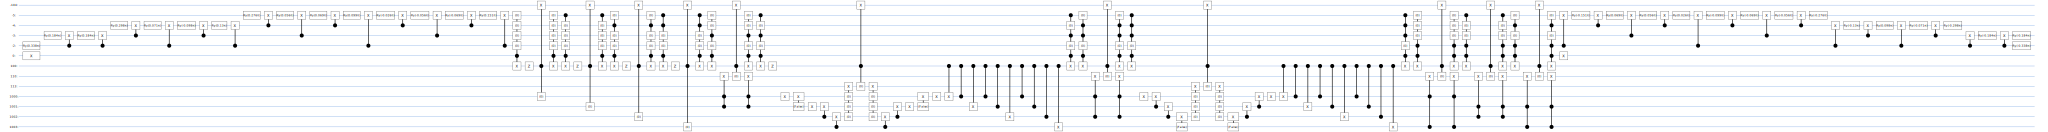

In [18]:
circuit = cirq.Circuit(gates)
SVGCircuit(circuit)

In [60]:
metrics.display_metrics()

--- Metrics ---
Number of elbows:  6042
Number of T-gates:  0
Number of non-Clifford rotations:  4090
---------------


In [61]:
lcu_metrics, _, _, _ = lcuify(op_fermionic_molecular_hamiltonian)

Too many qubits to validate: 34


In [62]:
lcu_metrics.display_metrics()

--- Metrics ---
Number of elbows:  2942
Number of T-gates:  0
Number of non-Clifford rotations:  8168
---------------


In [19]:
basis = get_basis_of_full_system(1, new_hamiltonian.max_fermionic_mode + 1, 0)
matrix = generate_matrix(new_hamiltonian, basis)

In [20]:
matrix.real.round(2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.59,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.59,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.18,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.2 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.11,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.28,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.08,  0.  ,  0.  ,
        -0.2 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.24,  0.  ,
         0.  ,  0.  ,  0. 

In [21]:
unitary = circuit.unitary()[
    :1<<system.number_of_system_qubits, :1<<system.number_of_system_qubits
] * overall_rescaling_factor

In [22]:
overall_rescaling_factor

6.513159919187991

In [23]:
unitary.real.round(2)

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.59,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.59,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -1.18,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.2 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.11,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.28,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.08,  0.  ,  0.  ,
        -0.2 ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.24,  0.  ,
         0.  ,  0.  ,  0. 

In [25]:
from openparticle import ParticleOperator
fermionic_molecular_hamiltonian = ParticleOperator('', hf_obj.energy_nuc())

for (p,q), coeff in one_body_coefficients.items():
        fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}', coeff)
for (p,q,r,s), coeff in two_body_coefficients.items():
        if p==q or r==s:
                pass
        else:
                if len(set([p,q,r,s])) == 4:
                        fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', coeff*.5)
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', -coeff*.5)
                        elif p == s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r} ', coeff*.5)
                        elif q == r:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s} ', coeff*.5)
       a                 elif q == s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}  ', -coeff*.5)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', coeff*.5)
                        elif p==r:
                                # implies q==s:
                                fermionic_molecular_hamiltonian +=  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s} ', -coeff*.5)


        

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 19)

In [ ]:
# from openparticle import ParticleOperator
# fermionic_molecular_hamiltonian = ParticleOperator('', hf_obj.energy_nuc())

# for (p,q), coeff in one_body_coefficients.items():
#         fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}', coeff)
# for (p,q,r,s), coeff in two_body_coefficients.items():
#         #Two-body terms bp^ bq^ br bs = delta(r, q) bp^ bs - bp^ br bq^ bs
#         # if p == r == q == s:
#         #         pass
#         # elif p == q == r:
#         #         # fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{s}', coeff*.5)
#         #         pass
#         # elif r == q == s:
#         #         pass
#         # elif p == q or r == s:
#         #         pass
#         # elif p == s:
#         #         if s != q != r:
#         #                 fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{s} b{r} b{q}^', coeff*.5)
#         #         elif r == q:
#         #                 fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{s} b{r} b{q}^', coeff*.5)
#         #         # #bp^ bq^ br bp
#         #         # #Scenario where indices aren't grouped as pairs
#         #         # fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{p} b{q}^ b{r}')
#         # elif q == r and p != s:
#         #         #bp^ bq^ bq bs
#         #         fermionic_molecular_hamiltonian += ParticleOperator(f'b{p}^ b{q}^ b{q} b{s}')
#         # else:
#         #         fermionic_molecular_hamiltonian += int(r == q) * ParticleOperator(f'b{p}^ b{s}', coeff*.5) - ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}', coeff*.5)

In [ ]:
fermionic_molecular_hamiltonian

2.29310124732 * 
-1.8351086963168037 * b0^ b0
0.15995609684251796 * b0^ b4
-1.8351086963168037 * b1^ b1
0.15995609684251796 * b1^ b5
-1.550652517950251 * b2^ b2
0.129467473891879 * b2^ b6
-1.550652517950251 * b3^ b3
0.129467473891879 * b3^ b7
0.15995609684251777 * b4^ b0
-1.2458017537486519 * b4^ b4
0.15995609684251777 * b5^ b1
-1.2458017537486519 * b5^ b5
0.12946747389187874 * b6^ b2
-0.9063250024040329 * b6^ b6
0.12946747389187874 * b7^ b3
-0.9063250024040329 * b7^ b7
0.24864241698725373 * b0^ b0 b1^ b1
-0.040782596583796904 * b0^ b1^ b1 b4
-0.07869102712081494 * b0^ b3 b1^ b2
0.021541988779363634 * b0^ b3 b1^ b6
-0.04078259658379692 * b0^ b0 b1^ b5
-0.05391606054203775 * b0^ b5 b1^ b4
0.02154198877936362 * b0^ b7 b1^ b2
-0.0485347484996618 * b0^ b7 b1^ b6
0.13927501691263766 * b0^ b0 b2^ b2
-0.020581805941815197 * b0^ b0 b2^ b6
-0.044097900462998205 * b0^ b2^ b2 b4
-0.02648027983443004 * b0^ b4 b2^ b6
-0.049256491459367904 * b0^ b6 b2^ b4
-0.07869102712081494 * b0^ b1 b3^ b2
0.02154

In [ ]:
const = fermionic_molecular_hamiltonian.op_dict.pop(())
fermionic_molecular_hamiltonian.remove_identity()

0

In [ ]:
(ParticleOperator('b0^ b4') + ParticleOperator('b4^ b0') + ParticleOperator('b1^ b1')).group()

[1.0 * b0^ b4
 1.0 * b4^ b0,
 1.0 * b1^ b1]

In [ ]:
fermionic_molecular_hamiltonian.group()

[-1.8351086963168037 * b0^ b0,
 0.15995609684251796 * b0^ b4,
 -1.8351086963168037 * b1^ b1,
 0.15995609684251796 * b1^ b5,
 -1.550652517950251 * b2^ b2,
 0.129467473891879 * b2^ b6,
 -1.550652517950251 * b3^ b3,
 0.129467473891879 * b3^ b7,
 0.15995609684251777 * b4^ b0,
 -1.2458017537486519 * b4^ b4,
 0.15995609684251777 * b5^ b1,
 -1.2458017537486519 * b5^ b5,
 0.12946747389187874 * b6^ b2,
 -0.9063250024040329 * b6^ b6,
 0.12946747389187874 * b7^ b3,
 -0.9063250024040329 * b7^ b7,
 -0.49728483397450746 * b1^ b0^ b1 b0,
 -0.08156519316759382 * b1^ b0^ b4 b1
 -0.08156519316759382 * b4^ b1^ b1 b0,
 -0.15738205424162988 * b1^ b0^ b3 b2
 -0.15738205424162988 * b3^ b2^ b1 b0,
 -0.043083977558727254 * b1^ b0^ b6 b3
 -0.043083977558727254 * b6^ b3^ b1 b0,
 0.08156519316759382 * b1^ b0^ b5 b0
 0.08156519316759382 * b5^ b0^ b1 b0,
 -0.1078321210840755 * b1^ b0^ b5 b4
 -0.1078321210840755 * b5^ b4^ b1 b0,
 0.043083977558727254 * b1^ b0^ b7 b2
 0.043083977558727254 * b7^ b2^ b1 b0,
 -0.0970694

In [ ]:
# basis_fermion = get_fock_basis(fermionic_molecular_hamiltonian)
# matrix = generate_matrix(fermionic_molecular_hamiltonian, basis_fermion)
# vals  = np.linalg.eigvalsh(matrix.real)

from scipy import sparse
vals, vecs = sparse.linalg.eigsh(fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode).to_sparse_matrix.real)

In [ ]:
E0_openparticle = min(vals) + const
E0_openparticle

-2.166387448634766

In [ ]:
fci_obj.e_tot - E0_openparticle

3.552713678800501e-15

In [ ]:
def get_fermionic_modes(operator):
    cleaned_modes = []
    cleaned_types = []

    assert len(operator.to_list()) == 1

    modes = list(tuple(t[1] for t in list(operator.op_dict.keys())[0]))
    types = list(tuple(t[-1] for t in list(operator.op_dict.keys())[0]))
    # print("---", operator, "---")
    # print("before cleaning", modes, types)

    i = 0
    while i < len(modes):
        if i != len(modes) - 1 and modes[i] == modes[i + 1] and types[i] == 1 and types[i + 1] == 0:
            cleaned_modes.append(modes[i])
            cleaned_types.append(2)
            i += 2
            continue
        else:
            cleaned_modes.append(modes[i])
            cleaned_types.append(types[i])
            i += 1
    
    # print("after cleaning", cleaned_modes, cleaned_types)
    return tuple(cleaned_modes[::-1]), tuple(cleaned_types[::-1])

In [ ]:
grouped_terms = fermionic_molecular_hamiltonian.to_list()

number_of_block_encoding_ancillae = 1
index_register = [
    cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(grouped_terms)))))
]
block_encoding_ancillae = [
    cirq.LineQubit(-100 - i - len(index_register))
    for i in range(number_of_block_encoding_ancillae)
]
print(block_encoding_ancillae)
number_of_block_encoding_ancillae = len(block_encoding_ancillae)
ctrls = ([cirq.LineQubit(0)], [1])
clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
system = System(
    fermionic_molecular_hamiltonian.max_fermionic_mode + 1,
    0,
    1000,
    True,
    False,
    False,
)

block_encoding_functions = []
rescaling_factors = []
for term in grouped_terms:
    plus_hc = False
    if len(term) == 2:
        plus_hc = True
        term = term.to_list()[0]
    active_modes, operator_types = get_fermionic_modes(term)
    print(term, active_modes, operator_types)
    if not plus_hc:
        
        block_encoding_functions.append(
            partial(
                fermionic_product_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(1)
    else:
        block_encoding_functions.append(
            partial(
                fermionic_plus_hc_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae,
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )

rescaled_coefficients = []
for term, rescaling_factor in zip(grouped_terms, rescaling_factors):
    rescaled_coefficients.append(
        term.coeffs[0] * rescaling_factor / max(rescaling_factors)
    )

target_state = get_target_state(rescaled_coefficients)
gates = []
metrics = CircuitMetrics()

gates.append(cirq.X.on(ctrls[0][0]))

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

_gates, _metrics = index_over_terms(
    index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls
)
print("Metrics from index_over_terms: \n")
_metrics.display_metrics() #Print metrics
gates += _gates
metrics += _metrics

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, dagger=True, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

gates.append(cirq.X.on(ctrls[0][0]))

overall_rescaling_factor = sum(
    [
        term.coeffs[0] * rescaling_factor
        for term, rescaling_factor in zip(grouped_terms, rescaling_factors)
    ]
)

print("Total metrics of the block encoding: \n")
metrics.display_metrics()


------
-0.9945696679490149 * b1^ b0^ b1 b0

found hermie -0.9945696679490149 * b1^ b0^ b1 b0

------
-0.16313038633518764 * b1^ b0^ b4 b1

not hermitian
copied 1 * b4^ b1^ b1 b0
 1 * b4^ b1^ b1 b0

copied -0.16313038633518764 -0.16313038633518764
found hc
------
-0.16313038633518764 * b4^ b1^ b1 b0

------
-0.31476410848325975 * b1^ b0^ b3 b2

not hermitian
copied 1 * b3^ b2^ b1 b0
 1 * b3^ b2^ b1 b0

copied -0.31476410848325975 -0.31476410848325975
found hc
------
-0.31476410848325975 * b3^ b2^ b1 b0

------
-0.08616795511745451 * b1^ b0^ b6 b3

not hermitian
copied 1 * b6^ b3^ b1 b0
 1 * b6^ b3^ b1 b0

copied -0.08616795511745451 -0.08616795511745451
found hc
------
-0.08616795511745451 * b6^ b3^ b1 b0

------
0.16313038633518764 * b1^ b0^ b5 b0

not hermitian
copied 1 * b5^ b0^ b1 b0
 1 * b5^ b0^ b1 b0

copied 0.16313038633518764 0.16313038633518764
found hc
------
0.16313038633518764 * b5^ b0^ b1 b0

------
-0.215664242168151 * b1^ b0^ b5 b4

not hermitian
copied 1 * b5^ b4^ b1 b0


ValueError: Duplicate qids for <cirq.ControlledGate(sub_gate=cirq.X, control_values=cirq.ProductOfSums(((1,), (1,), (0,), (0,))),control_qid_shape=(2, 2, 2, 2))>. Expected unique qids but got <(cirq.LineQubit(1000), cirq.LineQubit(1001), cirq.LineQubit(1000), cirq.LineQubit(1001), cirq.LineQubit(101))>.

In [ ]:
# check_unitary(operator, cirq.Circuit(gates), system, overall_rescaling_factor)
_validate_block_encoding(cirq.Circuit(gates), system, overall_rescaling_factor, fermionic_molecular_hamiltonian, 1 + len(index_register), 1)

Skipped: Too many qubits to validate: 21

In [ ]:
len(fermionic_molecular_hamiltonian)

1248

In [ ]:
len(fermionic_molecular_hamiltonian.group())

368

In [ ]:
def get_active_fermionic_modes(operator):
    active_modes = []
    for term in operator.to_list():
        for op in term.split():
            index = str(op)[str(op).index("b")+1:]
            if "^" in index:
                index = index[:-2]
            index = int(index)
            active_modes.append(index)
                
    return active_modes

def lobe_order_individual_op(op):
    n_modes = len(op.to_list()[0].split())
    assert n_modes in [2,4], 'not correct form. Either too many modes OR not a single operator'

    if n_modes==2:
            return op
    else:
        terms = get_active_fermionic_modes(op)
        if len(terms) == 4:
                p,q,r,s = terms
        
                if len(set([p,q,r,s])) == 4:
                        new_op = op
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op.coeff)
                        elif p == s:
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op.coeff)
                        elif q == r:
                                new_op = op
                                # new_op =  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s}  ', op.coeff)
                        elif q == s:
                                new_op =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op =  ParticleOperator(f'b{p}^  b{r} b{q}^ b{s}  ', -op.coeff)

                return new_op
        elif len(terms) == 8:
                op1, op1_dag = op.to_list()
                p,q,r,s = get_active_fermionic_modes(op1)

                if len(set([p,q,r,s])) == 4:
                        new_op  = op1
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op1.coeff)
                        elif p == s:
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1.coeff)
                        elif q == r:
                                new_op = op1
                                # new_op =  ParticleOperator(f'b{p}^ b{q}^ b{r} b{s}  ', op.coeff)
                        elif q == s:
                                new_op =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op1.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op =  ParticleOperator(f'b{p}^  b{r} b{q}^ b{s}  ', -op1.coeff)

                p,q,r,s = get_active_fermionic_modes(op1_dag)
                if len(set([p,q,r,s])) == 4:
                        new_op2 = op1_dag
                elif len(set([p,q,r,s])) == 3:
                        if p == r:
                                new_op2 =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op1_dag.coeff)
                        elif p == s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1_dag.coeff)
                        elif q == r:
                                new_op2 = op1_dag
                        elif q == s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{q}^ b{s} b{r}', -op1_dag.coeff)
                elif len(set([p,q,r,s])) == 2:
                        if p == s:
                                # implies q ==r
                                new_op2 =  ParticleOperator(f'b{p}^ b{s} b{q}^ b{r}', op1_dag.coeff)
                        elif p==r:
                                # implies q==s:
                                new_op2 =  ParticleOperator(f'b{p}^ b{r} b{q}^ b{s}  ', -op.coeff)

                return new_op + new_op2

In [ ]:
[l for l in grouped if len(l.to_list()[0].split())==2][1]

0.15995609684251796 * b0^ b4

In [ ]:
grouped = fermionic_molecular_hamiltonian.group()

new_group = []
new_operator = ParticleOperator("", 0)
for mini in grouped:
    new_group.append(lobe_order_individual_op(mini))
    new_operator+= lobe_order_individual_op(mini)

In [ ]:
## check they are the same!

g = ParticleOperator("")
for op in grouped:
    g+=op
g.op_dict.pop(())
# (g - new_operator).normal_order()

out = g.to_paulis(g.max_fermionic_mode) - new_operator.to_paulis(new_operator.max_fermionic_mode)
out.n_terms

0

In [ ]:
(g - fermionic_molecular_hamiltonian).order_indices()

0

In [ ]:
len(grouped),len(new_group), len(fermionic_molecular_hamiltonian)

(116, 116, 376)

In [ ]:
grouped = fermionic_molecular_hamiltonian.group()
g = ParticleOperator("",0)
for op in grouped:
    g+=op
# g.op_dict.pop(())

(g.to_paulis(g.max_fermionic_mode) - fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode)).coeff_vec

array([2.22044605e-15+0.j])

In [ ]:
(new_operator.to_paulis(new_operator.max_fermionic_mode) - fermionic_molecular_hamiltonian.to_paulis(fermionic_molecular_hamiltonian.max_fermionic_mode)).coeff_vec

array([2.22044605e-15+0.j])

In [ ]:
len(new_operator), len(grouped), len(new_group)

(184, 116, 116)

In [ ]:
len(fermionic_molecular_hamiltonian)

376

In [ ]:
lcu = LCU(fermionic_molecular_hamiltonian, None)
lcu.paulis.n_terms - 1 #neg 1 for identity!

184

In [ ]:
len(new_group)

116

In [ ]:
SVGCircuit(cirq.Circuit(gates))

In [ ]:
lcu = LCU(fermionic_molecular_hamiltonian, None)
lcu.paulis.n_terms

185

In [ ]:
# grouped_terms = new_operator.to_list()
# grouped_terms = grouped
grouped_terms = new_group

number_of_block_encoding_ancillae = 1
index_register = [
    cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(grouped_terms)))))
]
block_encoding_ancillae = [
    cirq.LineQubit(-100 - i - len(index_register))
    for i in range(number_of_block_encoding_ancillae)
]
print(block_encoding_ancillae)
number_of_block_encoding_ancillae = len(block_encoding_ancillae)
ctrls = ([cirq.LineQubit(0)], [1])
clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
system = System(
    fermionic_molecular_hamiltonian.max_fermionic_mode + 1,
    0,
    1000,
    True,
    False,
    False,
)

block_encoding_functions = []
rescaling_factors = []
for term in grouped_terms:
    plus_hc = False
    if len(term) == 2:
        plus_hc = True
        term = term.to_list()[0]
    active_modes, operator_types = get_fermionic_modes(term)
    print(term, active_modes, operator_types)
    if not plus_hc:
        
        block_encoding_functions.append(
            partial(
                fermionic_product_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(1)
    else:
        block_encoding_functions.append(
            partial(
                fermionic_plus_hc_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[0],
                active_indices=active_modes,
                operator_types = operator_types,
                sign = np.sign(term.coeff),
                clean_ancillae=clean_ancillae[1:],
            )
        )
        rescaling_factors.append(2)

rescaled_coefficients = []
for term, rescaling_factor in zip(grouped_terms, rescaling_factors):
    rescaled_coefficients.append(
        term.coeffs[0] * rescaling_factor / max(rescaling_factors)
    )

target_state = get_target_state(rescaled_coefficients)
gates = []
metrics = CircuitMetrics()

gates.append(cirq.X.on(ctrls[0][0]))

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

_gates, _metrics = index_over_terms(
    index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls
)
print("Metrics from index_over_terms: \n")
_metrics.display_metrics() #Print metrics
gates += _gates
metrics += _metrics

_gates, _metrics = add_prepare_circuit(
    index_register, target_state, dagger=True, clean_ancillae=clean_ancillae
)
print("Metrics from add_prepare_circuit: \n")
_metrics.display_metrics()
gates += _gates
metrics += _metrics

gates.append(cirq.X.on(ctrls[0][0]))

overall_rescaling_factor = sum(
    [
        term.coeffs[0] * rescaling_factor
        for term, rescaling_factor in zip(grouped_terms, rescaling_factors)
    ]
)

print("Total metrics of the block encoding: \n")
metrics.display_metrics()


[cirq.LineQubit(-107)]
-1.8351086963168037 * b0^ b0
 (0,) (2,)
0.15995609684251796 * b0^ b4
 (4, 0) (0, 1)
-1.8351086963168037 * b1^ b1
 (1,) (2,)
0.15995609684251796 * b1^ b5
 (5, 1) (0, 1)
-1.550652517950251 * b2^ b2
 (2,) (2,)
0.129467473891879 * b2^ b6
 (6, 2) (0, 1)
-1.550652517950251 * b3^ b3
 (3,) (2,)
0.129467473891879 * b3^ b7
 (7, 3) (0, 1)
0.15995609684251777 * b4^ b0
 (0, 4) (0, 1)
-1.2458017537486519 * b4^ b4
 (4,) (2,)
0.15995609684251777 * b5^ b1
 (1, 5) (0, 1)
-1.2458017537486519 * b5^ b5
 (5,) (2,)
0.12946747389187874 * b6^ b2
 (2, 6) (0, 1)
-0.9063250024040329 * b6^ b6
 (6,) (2,)
0.12946747389187874 * b7^ b3
 (3, 7) (0, 1)
-0.9063250024040329 * b7^ b7
 (7,) (2,)
0.49728483397450746 * b1^ b1 b0^ b0
 (0, 1) (2, 2)
-0.08156519316759382 * b1^ b1 b0^ b4
 (4, 0, 1) (0, 1, 2)
-0.15738205424162988 * b1^ b0^ b3 b2
 (2, 3, 0, 1) (0, 0, 1, 1)
-0.043083977558727254 * b1^ b0^ b6 b3
 (3, 6, 0, 1) (0, 0, 1, 1)
-0.08156519316759382 * b1^ b0^ b0 b5
 (5, 0, 1) (0, 2, 1)
-0.107832121084

In [ ]:
cirq_lcu = LCU(fermionic_molecular_hamiltonian, 0).get_circuit()

In [ ]:
cirq_lcu

In [ ]:
int(np.ceil(np.log2(lcu.paulis.n_terms)))

8.0

In [ ]:
fasdfsd

In [ ]:
# [ParticleOperator(term.op_dict) for term in new_group]
import pickle
import os
data_to_save = [term.op_dict for term in new_group]


out_file_path = os.path.join(os.getcwd(), 'WILL.pickle')
print('saving at:', out_file_path)
with open(out_file_path, 'wb') as outfile:
    pickle.dump(data_to_save, outfile)

saving at: /Users/carterm.gustin/Documents/PhDCode/Lightfront/LOBE/LOBE/notebooks/WILL.pickle


In [ ]:
## open data
in_file_path = os.path.join(os.getcwd(), 'WILL.pickle')
with open(in_file_path, 'rb') as infile:
    data = pickle.load(infile)

grouped_ops_for_will = [ParticleOperator(op_dicts) for op_dicts in data]

[-4.7492364119798 * b0^ b0,
 0.10960153743201594 * b0^ b2,
 0.16815660166252872 * b0^ b4,
 -0.025658829875603077 * b0^ b10,
 -4.7492364119798 * b1^ b1,
 0.10960153743201594 * b1^ b3,
 0.16815660166252872 * b1^ b5,
 -0.025658829875603077 * b1^ b11,
 0.10960153743201584 * b2^ b0,
 -1.53207872356986 * b2^ b2,
 0.035618490618169296 * b2^ b4,
 -0.08312192374154082 * b2^ b10,
 0.10960153743201584 * b3^ b1,
 -1.53207872356986 * b3^ b3,
 0.035618490618169296 * b3^ b5,
 -0.08312192374154082 * b3^ b11,
 0.16815660166252852 * b4^ b0,
 0.03561849061816917 * b4^ b2,
 -1.1325306577734406 * b4^ b4,
 0.032303096756846866 * b4^ b10,
 0.16815660166252852 * b5^ b1,
 0.03561849061816917 * b5^ b3,
 -1.1325306577734406 * b5^ b5,
 0.032303096756846866 * b5^ b11,
 -1.145344338651623 * b6^ b6,
 -1.145344338651623 * b7^ b7,
 -1.1453443386516236 * b8^ b8,
 -1.1453443386516236 * b9^ b9,
 -0.02565882987560297 * b10^ b0,
 -0.08312192374154066 * b10^ b2,
 0.03230309675684678 * b10^ b4,
 -0.9335824975776704 * b10^ b1

KeyboardInterrupt: 

In [ ]:
len(new_operator)

630